# import

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import datetime
# 自作モデルのインポート
import models.ore_no_zenketugou_model as zenketu
import models.train_loop as train_loop #訓練ループを格納
import class_name # ラベルの呼び出し

# データの準備

In [2]:
# cifar100を利用する
data_path = './cifar-100'
# 訓練データと検証データのダウンロード
tensor_cifar100_train = datasets.CIFAR100(data_path,
                                          train=True,
                                          download=True,
                                          transform=transforms.ToTensor())
tensor_cifar100_val = datasets.CIFAR100(data_path,
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = class_name.class_names()
super_class_names = class_name.super_class_names()

## 画像の標準化

In [4]:
# テンソルを束ねる
imgs = torch.stack([img_t for img_t, _ in tensor_cifar100_train], dim = 3)

# RGB各々の平均、標準偏差を計算する
means = imgs.view(3,-1).mean(dim=1)
stds = imgs.view(3,-1).std(dim=1)

# 各画像データを標準化する
transformed_tensor_cifar100_train = datasets.CIFAR100(data_path,
                                                      train=True,
                                                      download=False,
                                                      transform=transforms.Compose([
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(means,stds),
                                                          transforms.RandomResizedCrop(size=32, scale=(0.8,1.0)), #データの拡大縮小及びアスペクト比の変更
                                                          transforms.RandomHorizontalFlip(p=0.3), # 画像をp％の確率で左右反転させる
                                                          transforms.RandomVerticalFlip(p=0.3), # 画像をp％の確率で上下反転させる
                                                          transforms.RandomRotation(degrees=(-89,89)), #-89~89度の間で回転させる
                                                          transforms.RandomPerspective(distortion_scale=0.2,p=0.3) #画像を確率pで射影変換する
                                                      ]))
transformed_tensor_cifar100_val = datasets.CIFAR100(data_path,
                                                   train=False,
                                                   download=False,
                                                   transform = transforms.Compose([
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(means,stds)
                                                   ]))

# モデル選択

In [31]:
cnn_num = 256
n_blocks = 3
# モデルのインスタンスの作成
model = zenketu.ResNetReLU(n_chans1=cnn_num, n_blocks=n_blocks)
# パラメータの数を確認
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list)

38555236

In [32]:
# パラメータの設定
# データローダーに入れることで、簡単にデータを取り扱う
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    transformed_tensor_cifar100_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)
val_loader = torch.utils.data.DataLoader(
    transformed_tensor_cifar100_val,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True)
# 学習率の設定
learning_rate = 1e-2
# パラメータの修正に確率的勾配降下方を利用
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
# 損失関数を定義
loss_fn = nn.CrossEntropyLoss()
# エポック数を設定
n_epochs = 50

In [33]:
# resnet_relu_cnn256, block3, relu, SDGmomentumで訓練中
model

ResNetReLU(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    (0): ResBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc1): Linear(in_features=16384, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=100, bias=True)
)

In [34]:
# モデルの訓練
model,loss_train_lists, loss_val_lists, train_accuracies,val_accuracies = train_loop.train_loop(n_epochs = n_epochs,
                                            optimizer=optimizer,
                                            model = model,
                                            loss_fn = loss_fn,
                                            train = train_loader,
                                            val = val_loader)

2023-02-02 11:50:58.512300Epoch:1,Traing_loss:4.4262830396009925,val_loss4.210968621976816
2023-02-02 11:55:55.961935Epoch:2,Traing_loss:3.9309477848829593,val_loss3.733692519983668
2023-02-02 12:00:44.461942Epoch:3,Traing_loss:3.549802091759695,val_loss3.3498332682688523
2023-02-02 12:41:41.874782Epoch:10,Traing_loss:2.659942283825746,val_loss2.858923448878489
2023-02-02 13:41:36.435733Epoch:20,Traing_loss:2.1327709654076608,val_loss2.802491718037113
2023-02-02 14:42:31.762264Epoch:30,Traing_loss:1.7508286245348512,val_loss2.891922373680552
2023-02-02 15:43:28.854324Epoch:40,Traing_loss:1.4839458416732416,val_loss3.516954596634883
2023-02-02 16:44:22.735194Epoch:50,Traing_loss:1.2826337351078565,val_loss3.884358737119444


# 結果表示

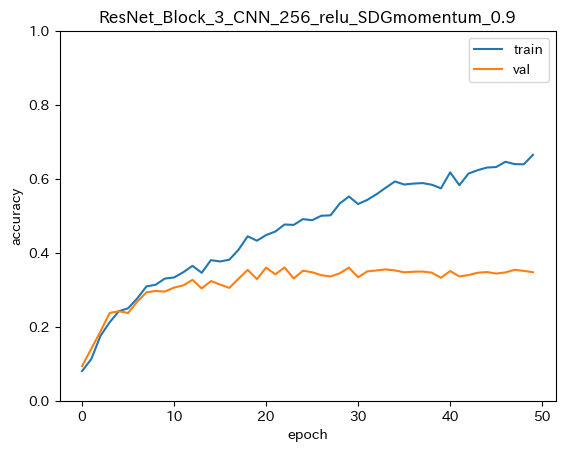

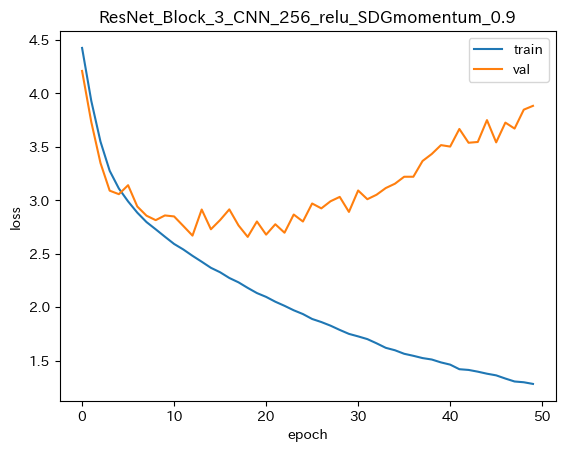

In [35]:
# 正解率を出す
title = 'ResNet_Block_3_CNN_256_relu_SDGmomentum_0.9'
plt.plot(train_accuracies,label = 'train')
plt.plot(val_accuracies, label ='val')
plt.title(f'{title}')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend()
plt.savefig(f'picture/accuracy_{title}.png')
plt.show()
# 損失
plt.plot(loss_train_lists,label = 'train')
plt.plot(loss_val_lists, label ='val')
plt.title(f'{title}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(f'picture/loss_{title}.png')
plt.show()

In [36]:
# モデルのパラメータの保存保存
d_path = './para_models/'
torch.save(model.state_dict(), d_path + f'{title}.pt')

# 結果を保存するためのdf

In [37]:
# データの読み込み
results_df = pd.read_csv('results_df.csv',index_col=0)
results_df

,date,name,archi,train_accuracy,val_accuracy,optimizer,n_epochs,batch_size,loss_fn,regularization
0,2023/01/27/17:40,ore_no_zenketugou,NN,1.000000,0.2000,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/11:48,ore_no_zenketugou_l2_0.001,NN,0.838520,0.2422,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/12:21,ore_no_zenketugou_dropout_0.3,NN,0.010840,0.0102,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/13:57,CNN,CNN,0.589320,0.2918,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/14:10,ore_no_zenketugou_dropout_0.05,NN,0.009860,0.0104,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/14:45,CNN_32,CNN,0.512720,0.3538,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/17:04,CNN128,NN,0.789920,0.3748,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:09,CNN_32_batchNorm,CNN,0.560440,0.3631,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:11,CNN_128_BatchNorm,CNN,0.872100,0.3873,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/19:25,ResNet_block_10_CNN_32,Res_CNN,0.110980,0.0902,SDG,300,100,CrossEntropyLoss(),0


In [38]:
# 追加したい結果をまとめたdfを作成
col = ['date','name','archi','train_accuracy','val_accuracy','optimizer',
       'n_epochs','batch_size','loss_fn','regularization']
add_df = pd.DataFrame([[datetime.datetime.now().strftime('%Y/%m/%d/%H:%M'),
                        title, 'ResNet_CNN', train_accuracies[-1],
                        val_accuracies[-1],'SDG', n_epochs, 100,
                        loss_fn, 0]],columns=col)
add_df

,date,name,archi,train_accuracy,val_accuracy,optimizer,n_epochs,batch_size,loss_fn,regularization
0,2023/02/02/17:36,ResNet_Block_3_CNN_256_relu_SDGmomentum_0.9,ResNet_CNN,0.665293,0.3477,SDG,50,100,CrossEntropyLoss(),0


In [39]:
# 結果を保存用dfに追加する
results_df = pd.concat([results_df, add_df], axis=0)
results_df

,date,name,archi,train_accuracy,val_accuracy,optimizer,n_epochs,batch_size,loss_fn,regularization
0,2023/01/27/17:40,ore_no_zenketugou,NN,1.000000,0.2000,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/11:48,ore_no_zenketugou_l2_0.001,NN,0.838520,0.2422,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/12:21,ore_no_zenketugou_dropout_0.3,NN,0.010840,0.0102,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/13:57,CNN,CNN,0.589320,0.2918,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/14:10,ore_no_zenketugou_dropout_0.05,NN,0.009860,0.0104,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/14:45,CNN_32,CNN,0.512720,0.3538,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/17:04,CNN128,NN,0.789920,0.3748,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:09,CNN_32_batchNorm,CNN,0.560440,0.3631,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:11,CNN_128_BatchNorm,CNN,0.872100,0.3873,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/19:25,ResNet_block_10_CNN_32,Res_CNN,0.110980,0.0902,SDG,300,100,CrossEntropyLoss(),0


In [40]:
# results_df.to_csv('final_results_df.csv') # 最終的に保存するためのdf
# results_df.to_csv('results_df.csv')

In [16]:
# モデルの呼び出し
# loaded_model = zenketu.ResNetTanh(n_chans1=256,n_blocks=6)
# loaded_model.load_state_dict(torch.load(d_path + 'ResNet_Block_6_CNN_256.pt'))